## **GAN para generar flores**

**1. Directorio de trabajo**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATA SCIENCE/NN'S/GAN/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/My Drive/DATA SCIENCE/NN'S/GAN


**2. Importamos las librerías necesarias**

In [ ]:
# generales:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
print('tensorflow version', tf.__version__)

tensorflow version 2.4.1


In [ ]:
# para las redes neuronales:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.datasets.cifar10 import load_data

In [ ]:
# para plotting:
from matplotlib import pyplot as plt

%matplotlib inline

**2. Cargando dataset**

In [ ]:
def loadImgs(dir=dir, batch=700):
  imgs = []
  fileList = []
  
  for root, dirs, files in os.walk(dir):
      for file in files:
          if file.endswith(".jpg"):
              fileList.append(file)

  for src in fileList[:batch]:
      img = Image.open(os.path.join(dir, src))
      imgs.append(np.asarray(img))

  return imgs

In [ ]:
imgs = loadImgs(dir="./dataset/flowers32")
print(np.array(imgs).shape)

(700, 32, 32, 3)


In [ ]:
imgs = np.array(imgs)
img_w, img_h = imgs.shape[1:3]

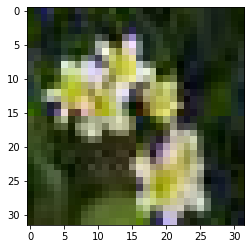

In [ ]:
plt.imshow(imgs[1, :, :, :])
plt.show()

## **(A) Red Discriminadora**

**1. Definimos el modelo de la red** 

In [ ]:
def discriminatorBuilder():
    model = Sequential(name='Discriminator')
    
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(img_w, img_h, 3)))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

**2. Definimos funciones que nos generen la información que entrenará a la discriminadora** 

In [ ]:
def generateRealImgs(data, batch=128):
    X = data[np.random.choice(data.shape[0], batch, replace=False)]
    # procesar y normalizar las imagenes [-1, 1]
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    # generar los targets para las imagenes reales (1)
    y = np.ones((batch, 1))
    return X, y

In [ ]:
""" OPCIONAL
"""
def generateFakeImgs(batch=128):
    # generar imagenes falsas
    X = np.random.uniform(-1.0, 1.0, size=[batch, img_w, img_h, 3])
    X = X.reshape((batch, img_w, img_h, 3))
    # generar los targets para las imagenes falsas (0)
    y = np.zeros((batch, 1))
    return X, y 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


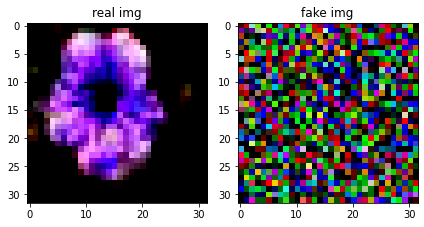

In [ ]:
""" OPCIONAL
"""
realX, realY = generateRealImgs(imgs)
fakeX, fakeY = generateFakeImgs()

# observar la instancia 5 tanto del batch de imagenes reales como de la falsas
axes = []
fig=plt.figure()
# real
axes.append(fig.add_subplot(1, 2, 1))
subplot_title=('real img')
axes[-1].set_title(subplot_title)
plt.imshow(realX[5, :, :, :])
# falsa
axes.append(fig.add_subplot(1, 2, 2))
subplot_title=('fake img')
axes[-1].set_title(subplot_title)
plt.imshow(fakeX[5, :, :, :])

fig.tight_layout()
plt.show()

**3. Proceso de entrenamiento de la red discriminadora** 

In [ ]:
""" OPCIONAL
"""
def trainDiscriminator(data, epochs=30, batch=128):
  # guardaremos las métricas de desempeño de la red discriminadora
  discMetrics = []
  # particionamos el batch para reales y falsas
  halfBatch = int(batch/2)

  for _ in range(epochs):
    realX, realY = generateRealImgs(data, batch=halfBatch)
    fakeX, fakeY = generateFakeImgs(batch=halfBatch)
    # creando una solo dataset
    X = np.concatenate((realX, fakeX))
    y = np.concatenate((realY, fakeY))
    # entrenar la red
    discMetrics.append(discriminator.train_on_batch(X, y))
    
  return discMetrics

**4. Instanciamos y compilamos nuestra red discriminadora** 

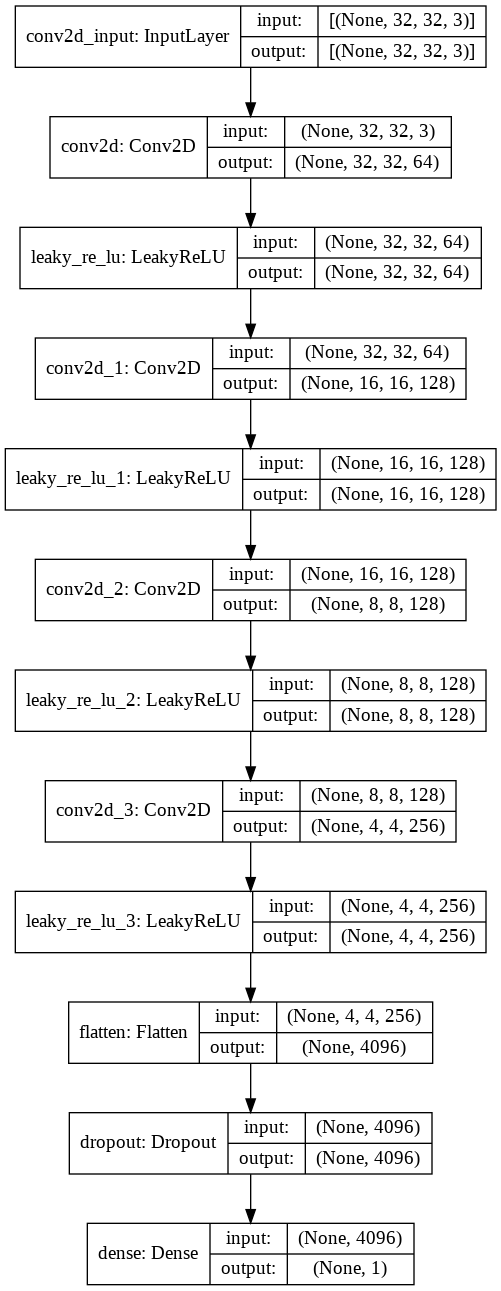

In [ ]:
# instanciamos y compilamos nuestra red discriminadora
discriminator = discriminatorBuilder()
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)

**5. Entrenamos la red discriminadora** 

[]

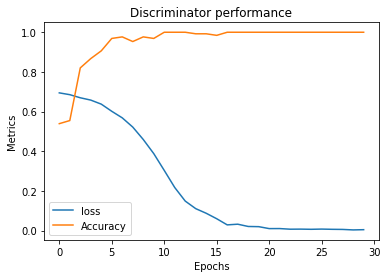

In [ ]:
""" OPCIONAL
"""
# observamos como la discriminadora aprende a discernir entre las imagenes
# falsas y las reales
discMetrics = trainDiscriminator(data=trainX)

# mostrando el loss de la red discriminadora
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in discMetrics],
    'Accuracy': [metric[1] for metric in discMetrics],
  }
).plot(title='Discriminator performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

## **(B) Red Generadora**

**1. Definimos el modelo de la red** 

In [ ]:
def generatorBuilder(z_dim=32):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

**2. Definimos una función para guardar el modelo de la red generadora** 

In [ ]:
""" OPCIONAL
"""
def saveGeneratorModel():
	# guardar el modelo de la red generadora
	filename = 'generator_flower_model.h5'
	generator.save(filename)

**3. Definimos una función para generar espacios latentes** 

In [ ]:
def generateLatentSpace(z_dim=32, batch=128):
    # generamos el espacio latente
    return np.random.uniform(-1.0, 1.0, size=[batch, z_dim])

In [ ]:
""" OPCIONAL
"""
# observamos el espacio latente generado
X = generateLatentSpace()
X.shape

(128, 32)

**4. Definimos una función para generar imágenes falsas a partir de la red generadora** 

In [ ]:
def generateFakeImgs(z_dim=32, batch=128):
    # generamos el espacio latente
    X = generateLatentSpace(batch=batch)
    # generar imagenes falsas
    X = generator.predict(X)
    # generar los targets para las imagenes falsas (0)
    y = np.zeros((batch, 1))

    return X, y 

**5. Instanciamos nuestra red generadora** 

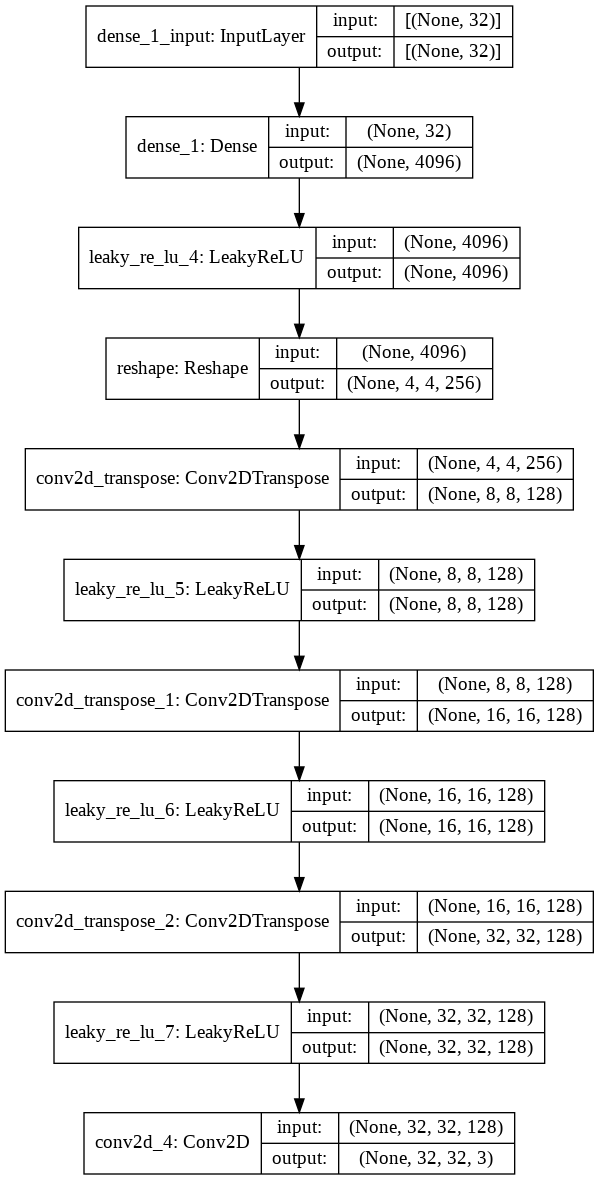

In [ ]:
# instanciamos nuestra red generadora
generator = generatorBuilder()
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True)

**5. Observamos una imagen falsa generada la red** 

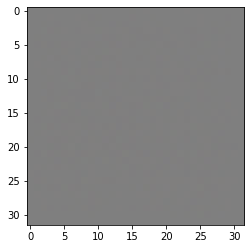

In [ ]:
""" OPCIONAL
"""
# generamos 128 imagenes falsas mediante la red generadora
fakeX, fakeY = generateFakeImgs()
# reescalamos las imágenes falsas
fakeX = (fakeX + 1) / 2.0

# observar la instancia 5 de nuestro batch generado por la red
plt.imshow(fakeX[5, :, :, :])
plt.show()

## **Red Adversarial**

**1. Definimos el modelo de la red adversarial en base a las redes discriminaroda y generadora** 

*ejecutar de nueva cuenta A4 y B5

In [ ]:
def GANBuilder(z_dim=32):
    model = Sequential(name='GAN')
    # Hacer pesos en la red discriminadora no entrenables
    discriminator.trainable = False
    # las redes generadora y discriminadora en cascada
    model.add(generator)
    model.add(discriminator)
    # compilamos la red adversarial y observamos el summary
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

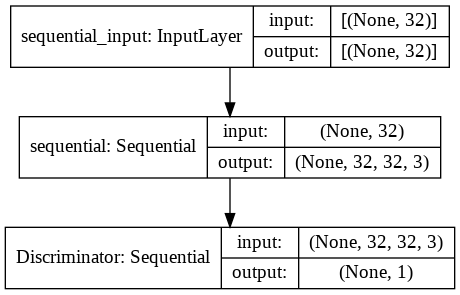

In [ ]:
# instanciamos nuestra red adversarial
gan = GANBuilder()
plot_model(gan, to_file='gan.png', show_shapes=True, show_layer_names=True)

**2. Proceso de entrenamiento de la red adversarial** 

In [ ]:
def train(data, epochs=2000, z_dim=32, batch=128, instances=5, save=False):
  # guardaremos las métricas de desempeño tanto de la red adversarial
  # como de la red discriminadora
  advrMetrics = []
  discMetrics = []
  
  # particionamos el batch para reales y falsas
  halfBatch = int(batch/2)

  for epoch in range(epochs):
    # (1) ENTRENAMIENTO DE LA RED DISCRIMINADORA
    realX, realY = generateRealImgs(data, batch=halfBatch)
    fakeX, fakeY = generateFakeImgs(batch=halfBatch)
    # creando una solo dataset
    X = np.concatenate((realX, fakeX))
    y = np.concatenate((realY, fakeY))
    # entrenar la red
    discMetrics.append(discriminator.train_on_batch(X, y))

    # (2) ENTRENAMIENTO DE LA RED GAN
    # generamos el espacio latente
    X = generateLatentSpace()
    # creamos etiquetas invertidas para las muestras falsas
    y = np.ones([batch, 1])
    # entrenar la red
    advrMetrics.append(gan.train_on_batch(X, y))
    
    # mostramos el progreso del entrenamiento y las imagenes que se van generando
    if (epoch + 1) % 100 == 0:
      print('epoch #{}'.format(epoch + 1))
      # generamos imagenes a partir de un espacio latente con
      # un numero determinado de instancias
      imgs = generator.predict(np.zeros([instances, z_dim]))
      # reescalamos las imágenes falsas
      imgs = (imgs + 1) / 2.0
      # dibujamos las imagenes
      plt.figure(figsize=(2, 2))
      for k in range(imgs.shape[0]):
        plt.subplot(1, instances,  k + 1)
        plt.imshow(imgs[k, :, :, :])
        plt.axis('off')
      plt.tight_layout()
      plt.show()
      
  # guaramos los pesos de la red generadora
  if save:
    saveGeneratorModel()
  return advrMetrics, discMetrics

In [ ]:
# almacenar las métricas de desempeño en caso de correr el algoritmo más de una vez
advrMetrics = []
discMetrics = []

epoch #100


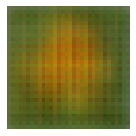

epoch #200


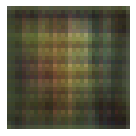

epoch #300


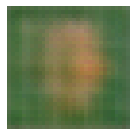

epoch #400


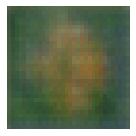

epoch #500


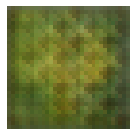

epoch #600


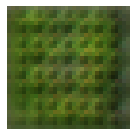

epoch #700


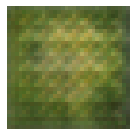

epoch #800


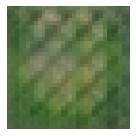

epoch #900


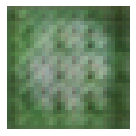

epoch #1000


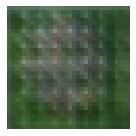

epoch #1100


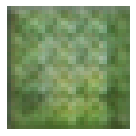

epoch #1200


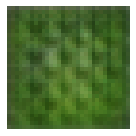

epoch #1300


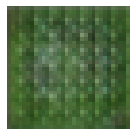

epoch #1400


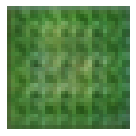

epoch #1500


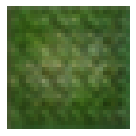

epoch #1600


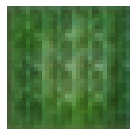

epoch #1700


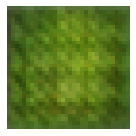

epoch #1800


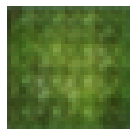

epoch #1900


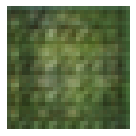

epoch #2000


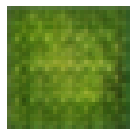

epoch #2100


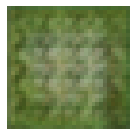

epoch #2200


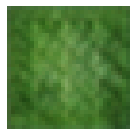

epoch #2300


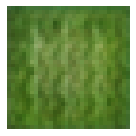

epoch #2400


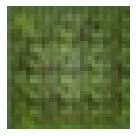

epoch #2500


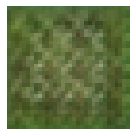

epoch #2600


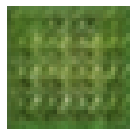

epoch #2700


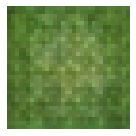

epoch #2800


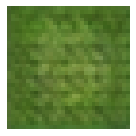

epoch #2900


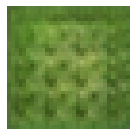

epoch #3000


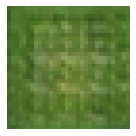

epoch #3100


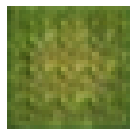

epoch #3200


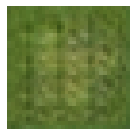

epoch #3300


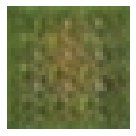

epoch #3400


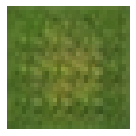

epoch #3500


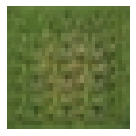

epoch #3600


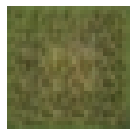

epoch #3700


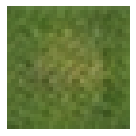

epoch #3800


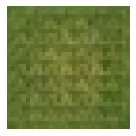

epoch #3900


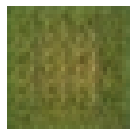

epoch #4000


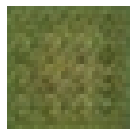

epoch #4100


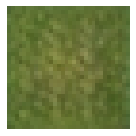

epoch #4200


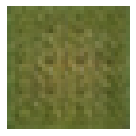

epoch #4300


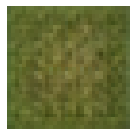

epoch #4400


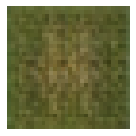

epoch #4500


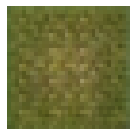

epoch #4600


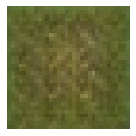

epoch #4700


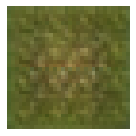

epoch #4800


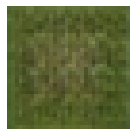

epoch #4900


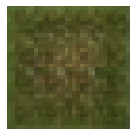

epoch #5000


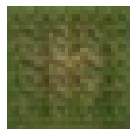

epoch #5100


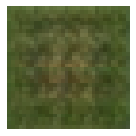

epoch #5200


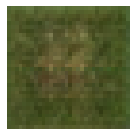

epoch #5300


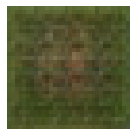

epoch #5400


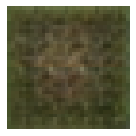

epoch #5500


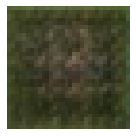

epoch #5600


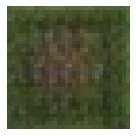

epoch #5700


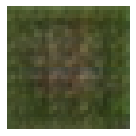

epoch #5800


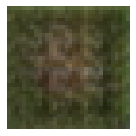

epoch #5900


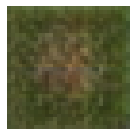

epoch #6000


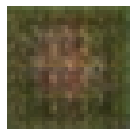

epoch #6100


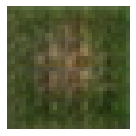

epoch #6200


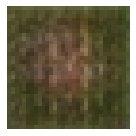

epoch #6300


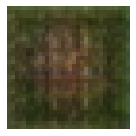

epoch #6400


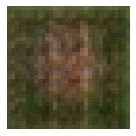

epoch #6500


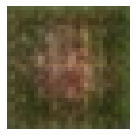

epoch #6600


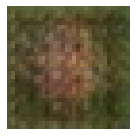

epoch #6700


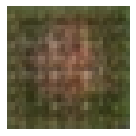

epoch #6800


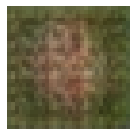

epoch #6900


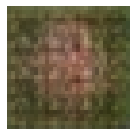

epoch #7000


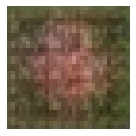

epoch #7100


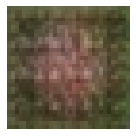

epoch #7200


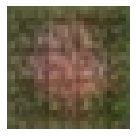

epoch #7300


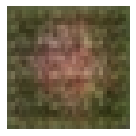

epoch #7400


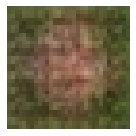

epoch #7500


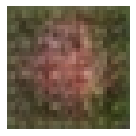

epoch #7600


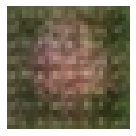

epoch #7700


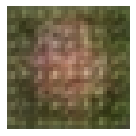

epoch #7800


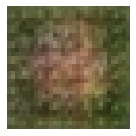

epoch #7900


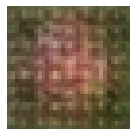

epoch #8000


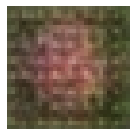

epoch #8100


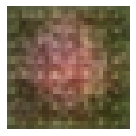

epoch #8200


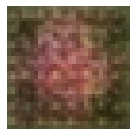

epoch #8300


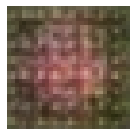

epoch #8400


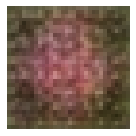

epoch #8500


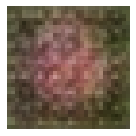

epoch #8600


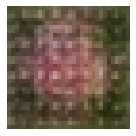

epoch #8700


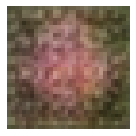

epoch #8800


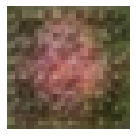

epoch #8900


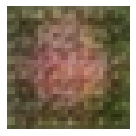

epoch #9000


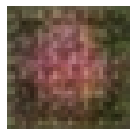

epoch #9100


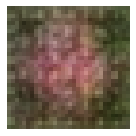

epoch #9200


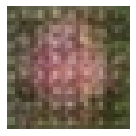

epoch #9300


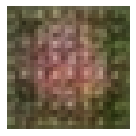

epoch #9400


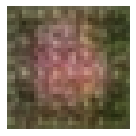

epoch #9500


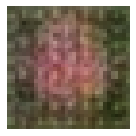

epoch #9600


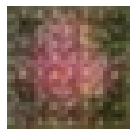

epoch #9700


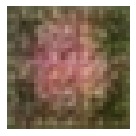

epoch #9800


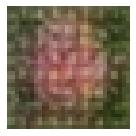

epoch #9900


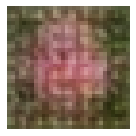

epoch #10000


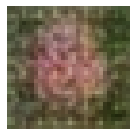

epoch #10100


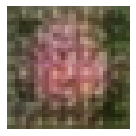

epoch #10200


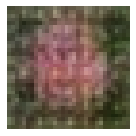

epoch #10300


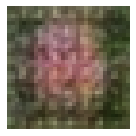

epoch #10400


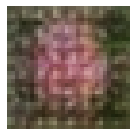

epoch #10500


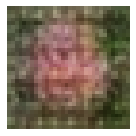

epoch #10600


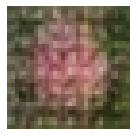

epoch #10700


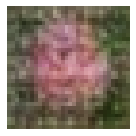

epoch #10800


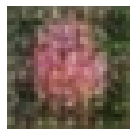

epoch #10900


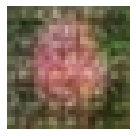

epoch #11000


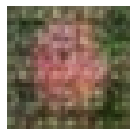

epoch #11100


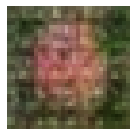

epoch #11200


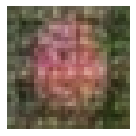

epoch #11300


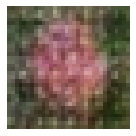

epoch #11400


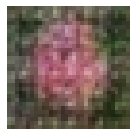

epoch #11500


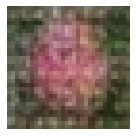

epoch #11600


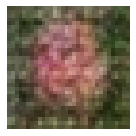

epoch #11700


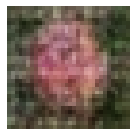

epoch #11800


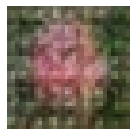

epoch #11900


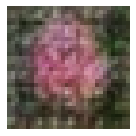

epoch #12000


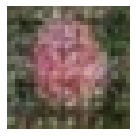

epoch #12100


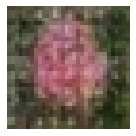

epoch #12200


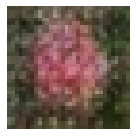

epoch #12300


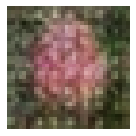

epoch #12400


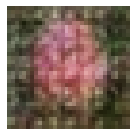

epoch #12500


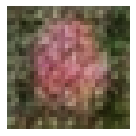

epoch #12600


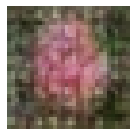

epoch #12700


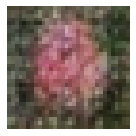

epoch #12800


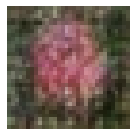

epoch #12900


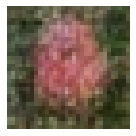

epoch #13000


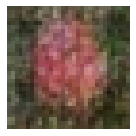

epoch #13100


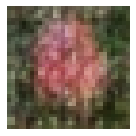

epoch #13200


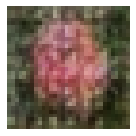

epoch #13300


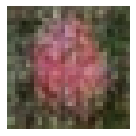

epoch #13400


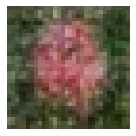

epoch #13500


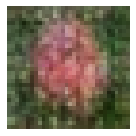

epoch #13600


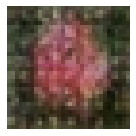

epoch #13700


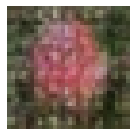

epoch #13800


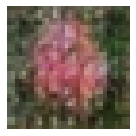

epoch #13900


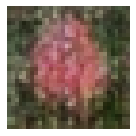

epoch #14000


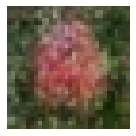

epoch #14100


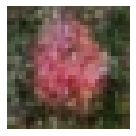

epoch #14200


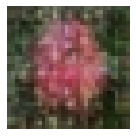

epoch #14300


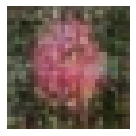

epoch #14400


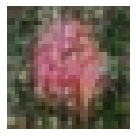

epoch #14500


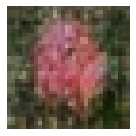

epoch #14600


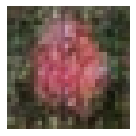

epoch #14700


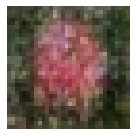

epoch #14800


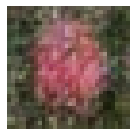

epoch #14900


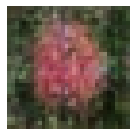

epoch #15000


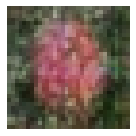

epoch #15100


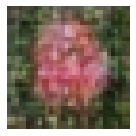

epoch #15200


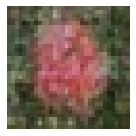

epoch #15300


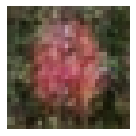

epoch #15400


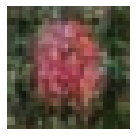

epoch #15500


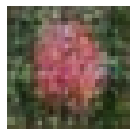

epoch #15600


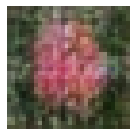

epoch #15700


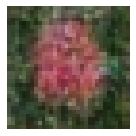

epoch #15800


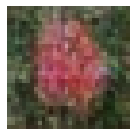

epoch #15900


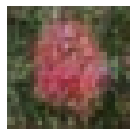

epoch #16000


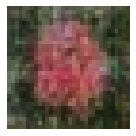

epoch #16100


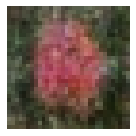

epoch #16200


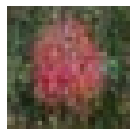

epoch #16300


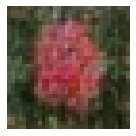

epoch #16400


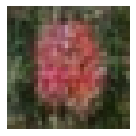

epoch #16500


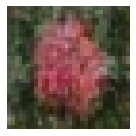

epoch #16600


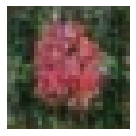

epoch #16700


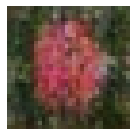

epoch #16800


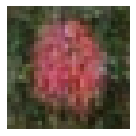

epoch #16900


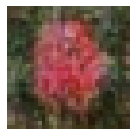

epoch #17000


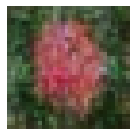

epoch #17100


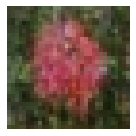

epoch #17200


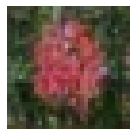

epoch #17300


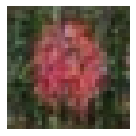

epoch #17400


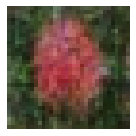

epoch #17500


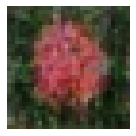

epoch #17600


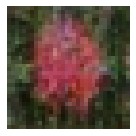

epoch #17700


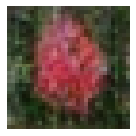

epoch #17800


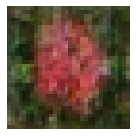

epoch #17900


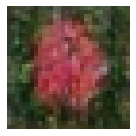

epoch #18000


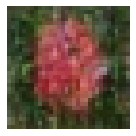

epoch #18100


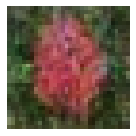

epoch #18200


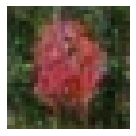

epoch #18300


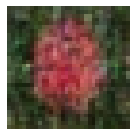

epoch #18400


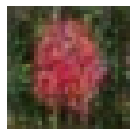

epoch #18500


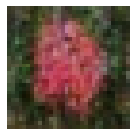

epoch #18600


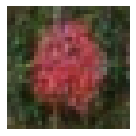

epoch #18700


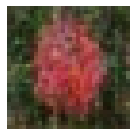

epoch #18800


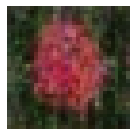

epoch #18900


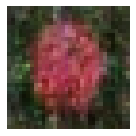

epoch #19000


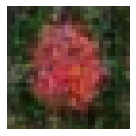

epoch #19100


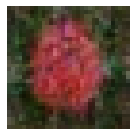

epoch #19200


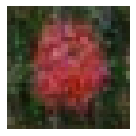

epoch #19300


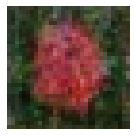

epoch #19400


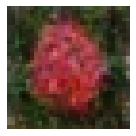

epoch #19500


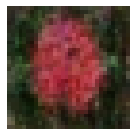

epoch #19600


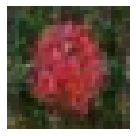

epoch #19700


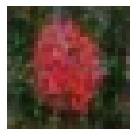

epoch #19800


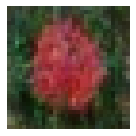

epoch #19900


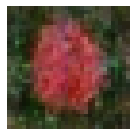

epoch #20000


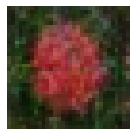

In [ ]:
# ejecutamos el algoritmo
aMetrics, dMetrics = train(data=imgs, epochs=20000, instances=1)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics